In [2]:
# DATA MANIPULATION
import numpy as np  
import pandas as pd 

# VISUALIZATION
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# MISC
import os
import cv2
import warnings
warnings.filterwarnings('ignore')
# import dicom to read the images
import pydicom as dicom

ModuleNotFoundError: ignored

In [ ]:
df1 = pd.read_csv('/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_detailed_class_info.csv')

In [ ]:
df1['class'].value_counts()

No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: class, dtype: int64

In [ ]:
df1.drop_duplicates(inplace=True)

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26684 entries, 0 to 30225
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   patientId  26684 non-null  object
 1   class      26684 non-null  object
dtypes: object(2)
memory usage: 625.4+ KB


In [ ]:
df1['class'].value_counts()

No Lung Opacity / Not Normal    11821
Normal                           8851
Lung Opacity                     6012
Name: class, dtype: int64

<AxesSubplot:xlabel='class', ylabel='count'>

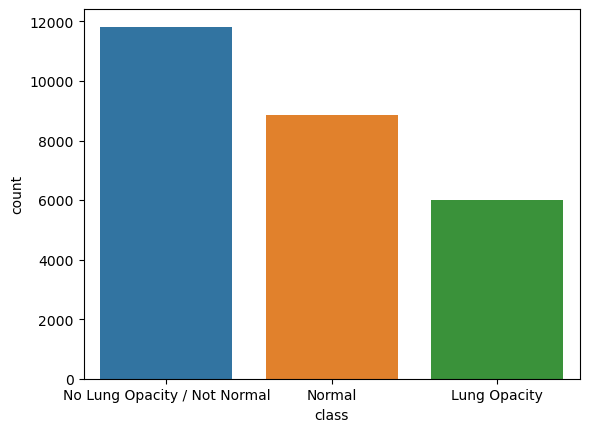

In [ ]:
sns.countplot(x='class', data=df1)

In [ ]:
classes = df1['class'].unique()
print(classes)

['No Lung Opacity / Not Normal' 'Normal' 'Lung Opacity']


In [ ]:
# We try to balance the dataset. Since we have many images (26.7kimages) and the length of lowest numbered class is 6012,
# we try to reduce each class to have 5000 images.
import random
np.random.seed(10)
df = pd.DataFrame(columns=['patientId','class'])
for cl in classes:
    df2 = df1[df1['class']==cl]
    n_remove = len(df2)-5000
    df2 = df2.sample(len(df2)-n_remove)
    print(df2.shape)
    df = df.append(df2,verify_integrity=True)
print(df.shape)
df = df.sort_index()
df.head()  
    

(5000, 2)
(5000, 2)
(5000, 2)
(15000, 2)


,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
8,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity
10,008c19e8-a820-403a-930a-bc74a4053664,No Lung Opacity / Not Normal


In [ ]:
df['class'].value_counts()

No Lung Opacity / Not Normal    5000
Normal                          5000
Lung Opacity                    5000
Name: class, dtype: int64

<AxesSubplot:xlabel='class', ylabel='count'>

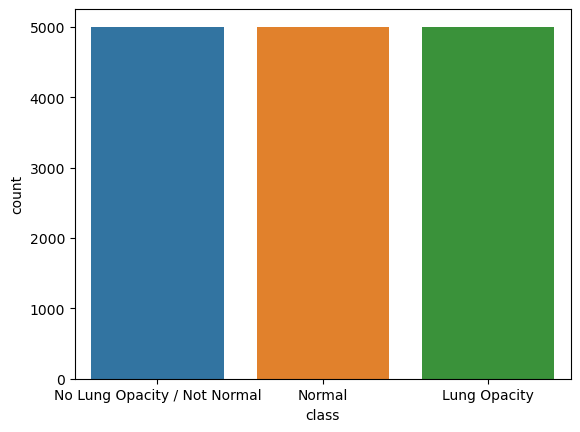

In [ ]:
sns.countplot(x='class',data=df)

In [ ]:
#store rows that we removed into another dataframe that can be used for testing
df_t = df1[~df1.isin(df)].dropna()
df_t['class'].value_counts()

No Lung Opacity / Not Normal    6821
Normal                          3851
Lung Opacity                    1012
Name: class, dtype: int64

In [ ]:
# Now we get 1000 rows of each class and form the testing data.
#min(df2['class'].value_counts())
import random
np.random.seed(10)
df_test = pd.DataFrame(columns=['patientId','class'])
for cl in classes:
    df2 = df_t[df_t['class']==cl]
    n_remove = len(df2)-1000
    df2 = df2.sample(len(df2)-n_remove)
    print(df2.shape)
    df_test = df_test.append(df2,verify_integrity=True)
print(df_test.shape)
df_test = df_test.sort_index()
df_test.head() 

(1000, 2)
(1000, 2)
(1000, 2)
(3000, 2)


,patientId,class
18,00d7c36e-3cdf-4df6-ac03-6c30cdc8e85b,No Lung Opacity / Not Normal
41,01a6eaa6-222f-4ea8-9874-bbd89dc1a1ce,Lung Opacity
55,01c0b605-0a82-401b-9649-81252304ac45,Normal
57,01cad8d0-45cd-4603-b099-94055d322310,Lung Opacity
92,020a16e3-baf9-4cf0-859c-c79b5253d717,Lung Opacity


In [ ]:
X = df['patientId']
Y = df['class']
x_test = df_test['patientId']
y_test = df_test['class']

In [ ]:
# Split the dataset into 4 sets for easier loading and avoiding memory errors, maintaining the same 'class' ratios.
# The idea is we train the model on each set separately and at the end store the weights. Load the weights back before training the next set.
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X, Y, stratify = Y, test_size = 0.5, random_state =42)
x1, x2, y1, y2 = train_test_split(x_train, y_train, stratify = y_train, test_size = 0.5, random_state =42)
x3, x4, y3, y4 = train_test_split(x_val, y_val, stratify = y_val, test_size = 0.5, random_state =42)

In [ ]:
print(x1.shape,y1.shape)
print(x2.shape,y2.shape)
print(x3.shape,y3.shape)
print(x4.shape,y4.shape)

(3750,) (3750,)
(3750,) (3750,)
(3750,) (3750,)
(3750,) (3750,)


In [ ]:
del X, Y
del df1, df2, df_t, df
del x_train, x_val, y_train, y_val

In [ ]:
import gc
gc.collect()

84

In [ ]:
# Now we need to replace the x? datasets that has patiendId with their corresponding actual images/pixel data. 
# We do this by defining a function
def populate_X_images(x):
    os.chdir('/kaggle/input/rsna-pneumonia-detection-challenge/')
    file_path='stage_2_train_images'
    x_img = pd.DataFrame(columns=['image'])
    for Id in x:
        fname = str(Id) + ".dcm"
        ds = dicom.dcmread(os.path.join(file_path,fname))
        x_img = x_img.append({'image':ds.pixel_array},ignore_index=True)
    return x_img

def populate_X_test_images():
    os.chdir('/kaggle/input/rsna-pneumonia-detection-challenge/')
    file_path='stage_2_test_images'
    x_img = pd.DataFrame(columns=['image'])
    for fname in os.listdir(file_path):
        ds = dicom.dcmread(os.path.join(file_path,fname))
        x_img = x_img.append({'image':ds.pixel_array},ignore_index=True)
    return x_img

# Define a new function to resize and reshape according to our needs
import cv2
def resize_reshape_x(x, shape: tuple):
    X_rsz = []
    for i in (x['image']):
        img = cv2.resize(i, shape)
        img = np.stack((img,)*3, axis=-1)
        X_rsz.append(img)
    return np.array(X_rsz)

# Vizualizing the images
def plot_sample(x,y):
    plt.figure(figsize=(20,20))
    n=3
    j=1
    sample = random.sample(range(0,len(x)),3)
    for i in sample:
        plt.subplot(1,n,j)
        plt.imshow(x[i])
        plt.title("{}".format(y.iloc[i]))
        j+=1
# pre-process data
def pre_process(x_tr, x_val, y_tr, y_val):
    x_tr = (x_tr/255).astype('float16')
    y_tr = pd.get_dummies(y_tr)
    x_val = (x_val/255).astype('float16')
    y_val = pd.get_dummies(y_val)
    return x_tr, x_val, y_tr, y_val

def pre_process_test(x_test, y_test):
    x_test = (x_test/255).astype('float16')
    y_test = pd.get_dummies(y_test)
    return x_test, y_test

# Loading the images, replacing the patientIds. Also resize them to required,shape
def load_image(x):
    x_img = populate_X_images(x)
    print('Populated Images\n')
    x_img = resize_reshape_x(x_img,(224,224))
    return x_img

In [ ]:
def create_model():
    import tensorflow as tf
    from tensorflow.keras.applications import DenseNet121
    from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, Flatten, Activation, MaxPooling2D, concatenate, Input, BatchNormalization
    from tensorflow.keras.models import Model, Sequential
    base_model = DenseNet121(input_shape=(224,224,3),
                              weights=None,
                              #pooling='avg',
                              include_top=False) 
    predictions = tf.keras.layers.Dense(14, activation='relu', name='predictions')(base_model.output)
    chexnet_model = tf.keras.Model(inputs=base_model.input, outputs=predictions)
    chexnet_model.load_weights('/kaggle/input/chexnet-augmented/CheXNet_Keras_0.3.0_weights.h5')
    for layer in base_model.layers[0:-11]: # last 11 layers need to be trained for better prediction
        layer.trainable = False
    #base_model.trainable = False
    #base_mode.summary()
    x = base_model.output
    #x = GlobalAveragePooling2D()(x)
    x = MaxPooling2D()(x)
    x = Flatten()(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.5)(x)
    preds = Dense(3, activation='softmax')(x) #final layer with softmax activation

    merged_model = Model([base_model.input],
                           outputs=preds)

    # Compile the model
    opt = tf.keras.optimizers.Adam(learning_rate=0.000001) #reduce lr 
    merged_model.compile(optimizer=opt,
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])

    #merged_model.summary()
    return merged_model

In [ ]:
# function to plot Accuracy and loss plots
def plot_hist(tr_hist):
    accuracy = tr_hist.history['accuracy']
    val_accuracy = tr_hist.history['val_accuracy']
    loss = tr_hist.history['loss']
    val_loss = tr_hist.history['val_loss']
    epochs   = range(len(accuracy)) # Get number of epochs

    plt.plot  (epochs, accuracy, label = 'training accuracy')
    plt.plot  (epochs, val_accuracy, label = 'validation accuracy')
    plt.title ('Training and validation accuracy')
    plt.legend(loc = 'lower right')
    plt.figure()

    plt.plot  (epochs, loss, label = 'training loss')
    plt.plot  (epochs, val_loss, label = 'validation loss')
    plt.legend(loc = 'upper right')
    plt.title ('Training and validation loss')

def plot_hist_simple(tr_hist):
    pd.DataFrame(tr_hist).plot()

In [ ]:
# Saving model and training history and its weights for future use
import pickle
def save_model_and_hist(model, hist, model_file, model_wght_file, hist_file):
    model.save(model_file)
    model.save_weights(model_wght_file)
    with open(hist_file, 'wb') as file_pi:
        pickle.dump(hist.history, file_pi)

# Load hist and plot
def load_and_plot_hist(model_name: str, i: int):
    hist_fname = "/kaggle/working/"+ model_name + "_hist" + str(i)
    with open(hist_fname, 'rb') as f:
        tr_hist = pickle.load(f)
    pd.DataFrame(tr_hist).plot()

# Load and return model
from tensorflow.keras.models import load_model
def load_and_return_model(modelname: str, j: int):
    model_fname = '/kaggle/working/'+ modelname + str(j) + ".h5"
    model = load_model(model_fname)
    return model

In [ ]:
import gc
gc.collect()

23

In [ ]:
import tensorflow.keras.callbacks as cb
def run_save_one_iteration(x_img, y, model, bsz, epo, modelname: str, j: int):
    #plot_sample(x_img, y)
    x_train, x_val, y_train, y_val = train_test_split(x_img, y, stratify = y, test_size = 0.2, random_state =42)
    x_train, x_val, y_train, y_val = pre_process(x_train, x_val, y_train, y_val)
    print(x_train.shape,y_train.shape,x_val.shape,y_val.shape)
    callback = cb.EarlyStopping(monitor='val_loss', patience = 10,restore_best_weights=True,start_from_epoch=10)
    tr_history = model.fit(x=[x_train],
                           y=y_train,
                           batch_size=bsz,
                           epochs=epo, 
                           validation_data=(x_val , y_val),
                           callbacks=callback
                           )
    #plot_hist_sample(tr_history)
    model_fname = '/kaggle/working/' + modelname + str(j) + ".h5"
    model_wname = '/kaggle/working/' + modelname + "_weights" + str(j) + ".h5"
    model_hname= '/kaggle/working/' + modelname + "_hist" + str(j)
    save_model_and_hist(model, tr_history, model_fname, model_wname, model_hname)
    del x_train, x_val, y_train, y_val, tr_history

In [ ]:
merged_model = create_model()
merged_model.load_weights('/kaggle/working/CheXNet_weights4.h5')

In [ ]:
x_img = load_image(x1)
gc.collect()
run_save_one_iteration(x_img, y1, merged_model, 18, 50, 'CheXNet', 1)

Populated Images

(3000, 224, 224, 3) (3000, 3) (750, 224, 224, 3) (750, 3)
Epoch 1/50
167/167 [==============================] - 26s 85ms/step - loss: 0.7321 - accuracy: 0.7097 - val_loss: 0.6830 - val_accuracy: 0.7493
Epoch 2/50
167/167 [==============================] - 10s 63ms/step - loss: 0.7263 - accuracy: 0.7083 - val_loss: 0.6852 - val_accuracy: 0.7467
Epoch 3/50
167/167 [==============================] - 10s 58ms/step - loss: 0.7230 - accuracy: 0.7047 - val_loss: 0.6850 - val_accuracy: 0.7480
Epoch 4/50
167/167 [==============================] - 10s 58ms/step - loss: 0.7436 - accuracy: 0.6933 - val_loss: 0.6796 - val_accuracy: 0.7480
Epoch 5/50
167/167 [==============================] - 10s 62ms/step - loss: 0.7350 - accuracy: 0.7067 - val_loss: 0.6818 - val_accuracy: 0.7480
Epoch 6/50
167/167 [==============================] - 9s 56ms/step - loss: 0.7364 - accuracy: 0.7037 - val_loss: 0.6820 - val_accuracy: 0.7467
Epoch 7/50
167/167 [==============================] - 9s 57ms

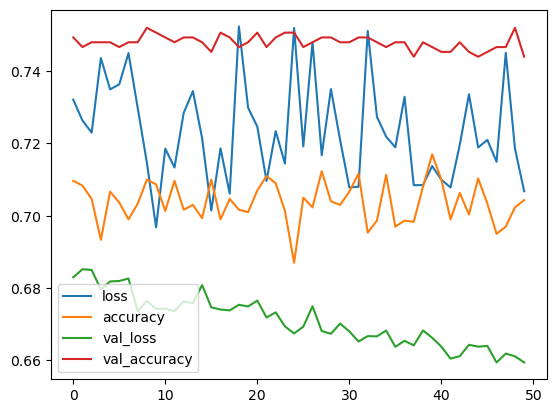

In [ ]:
load_and_plot_hist('CheXNet',1)
del x_img, merged_model
gc.collect()
model= load_and_return_model('CheXNet', 1)

Populated Images

(3000, 224, 224, 3) (3000, 3) (750, 224, 224, 3) (750, 3)
Epoch 1/50
94/94 [==============================] - 20s 127ms/step - loss: 0.6793 - accuracy: 0.7077 - val_loss: 0.6242 - val_accuracy: 0.7267
Epoch 2/50
94/94 [==============================] - 9s 98ms/step - loss: 0.6685 - accuracy: 0.7130 - val_loss: 0.6233 - val_accuracy: 0.7280
Epoch 3/50
94/94 [==============================] - 9s 100ms/step - loss: 0.6681 - accuracy: 0.7050 - val_loss: 0.6232 - val_accuracy: 0.7267
Epoch 4/50
94/94 [==============================] - 9s 98ms/step - loss: 0.6523 - accuracy: 0.7183 - val_loss: 0.6231 - val_accuracy: 0.7267
Epoch 5/50
94/94 [==============================] - 8s 87ms/step - loss: 0.6553 - accuracy: 0.7117 - val_loss: 0.6232 - val_accuracy: 0.7267
Epoch 6/50
94/94 [==============================] - 8s 87ms/step - loss: 0.6705 - accuracy: 0.7010 - val_loss: 0.6222 - val_accuracy: 0.7280
Epoch 7/50
94/94 [==============================] - 9s 100ms/step - loss: 0

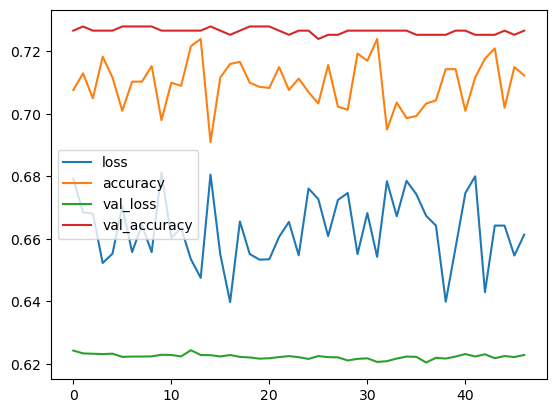

In [ ]:
x_img = load_image(x2)
gc.collect()
run_save_one_iteration(x_img, y2, model, 32, 50, 'CheXNet', 2)
load_and_plot_hist('CheXNet',2)

In [ ]:
del x_img, model
gc.collect()
model= load_and_return_model('CheXNet', 2)

Populated Images

(3000, 224, 224, 3) (3000, 3) (750, 224, 224, 3) (750, 3)
Epoch 1/50
94/94 [==============================] - 22s 138ms/step - loss: 0.6114 - accuracy: 0.7270 - val_loss: 0.6378 - val_accuracy: 0.7187
Epoch 2/50
94/94 [==============================] - 8s 86ms/step - loss: 0.6100 - accuracy: 0.7270 - val_loss: 0.6379 - val_accuracy: 0.7213
Epoch 3/50
94/94 [==============================] - 8s 87ms/step - loss: 0.6193 - accuracy: 0.7257 - val_loss: 0.6383 - val_accuracy: 0.7213
Epoch 4/50
94/94 [==============================] - 8s 85ms/step - loss: 0.6214 - accuracy: 0.7257 - val_loss: 0.6382 - val_accuracy: 0.7213
Epoch 5/50
94/94 [==============================] - 8s 86ms/step - loss: 0.6371 - accuracy: 0.7193 - val_loss: 0.6400 - val_accuracy: 0.7240
Epoch 6/50
94/94 [==============================] - 8s 86ms/step - loss: 0.6086 - accuracy: 0.7280 - val_loss: 0.6392 - val_accuracy: 0.7227
Epoch 7/50
94/94 [==============================] - 8s 88ms/step - loss: 0.5

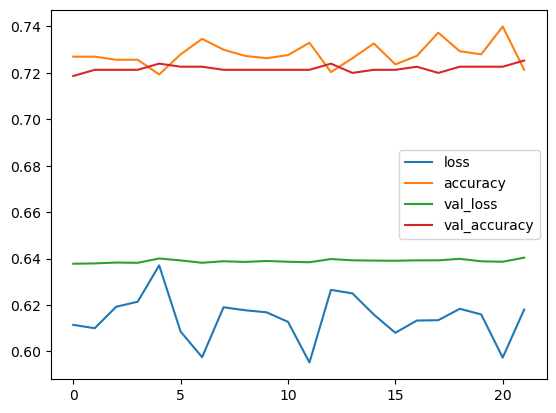

In [ ]:
gc.collect()
x_img = load_image(x3)
gc.collect()
run_save_one_iteration(x_img, y3, model, 32, 50, 'CheXNet', 3)
load_and_plot_hist('CheXNet',3)

In [ ]:
del x_img, model
gc.collect()
model= load_and_return_model('CheXNet', 3)

Populated Images

(3000, 224, 224, 3) (3000, 3) (750, 224, 224, 3) (750, 3)
Epoch 1/50
94/94 [==============================] - 20s 126ms/step - loss: 0.5604 - accuracy: 0.7577 - val_loss: 0.6170 - val_accuracy: 0.7427
Epoch 2/50
94/94 [==============================] - 8s 86ms/step - loss: 0.5470 - accuracy: 0.7603 - val_loss: 0.6162 - val_accuracy: 0.7413
Epoch 3/50
94/94 [==============================] - 8s 87ms/step - loss: 0.5657 - accuracy: 0.7513 - val_loss: 0.6184 - val_accuracy: 0.7413
Epoch 4/50
94/94 [==============================] - 9s 98ms/step - loss: 0.5690 - accuracy: 0.7507 - val_loss: 0.6180 - val_accuracy: 0.7440
Epoch 5/50
94/94 [==============================] - 9s 97ms/step - loss: 0.5597 - accuracy: 0.7507 - val_loss: 0.6178 - val_accuracy: 0.7427
Epoch 6/50
94/94 [==============================] - 9s 99ms/step - loss: 0.5646 - accuracy: 0.7370 - val_loss: 0.6178 - val_accuracy: 0.7467
Epoch 7/50
94/94 [==============================] - 9s 98ms/step - loss: 0.5

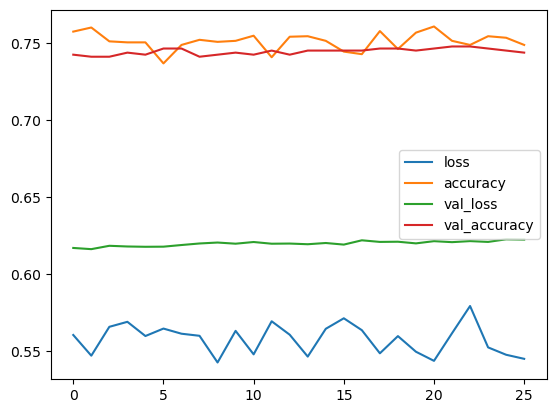

In [ ]:
gc.collect()
x_img = load_image(x4)
gc.collect()
run_save_one_iteration(x_img, y4, model, 32, 50, 'CheXNet', 4)
load_and_plot_hist('CheXNet',4)

In [ ]:
del x_img, model
gc.collect()
model= load_and_return_model('CheXNet', 4)

In [ ]:
# comment for second run
gc.collect()
x_img = load_image(x_test)
classes = y_test.unique()
x_test, y_test = pre_process_test(x_img, y_test)
gc.collect()

OSError: [Errno 36] File name too long: 'stage_2_train_images/[[[0.4275 0.4275 0.4275]\n  [0.3372 0.3372 0.3372]\n  [0.3215 0.3215 0.3215]\n  ...\n  [0.9253 0.9253 0.9253]\n  [0.937  0.937  0.937 ]\n  [0.961  0.961  0.961 ]]\n\n [[0.251  0.251  0.251 ]\n  [0.2274 0.2274 0.2274]\n  [0.2235 0.2235 0.2235]\n  ...\n  [0.8823 0.8823 0.8823]\n  [0.898  0.898  0.898 ]\n  [0.9136 0.9136 0.9136]]\n\n [[0.2196 0.2196 0.2196]\n  [0.2118 0.2118 0.2118]\n  [0.2118 0.2118 0.2118]\n  ...\n  [0.8354 0.8354 0.8354]\n  [0.851  0.851  0.851 ]\n  [0.8784 0.8784 0.8784]]\n\n ...\n\n [[0.4197 0.4197 0.4197]\n  [0.4197 0.4197 0.4197]\n  [0.4236 0.4236 0.4236]\n  ...\n  [0.741  0.741  0.741 ]\n  [0.8076 0.8076 0.8076]\n  [0.859  0.859  0.859 ]]\n\n [[0.4902 0.4902 0.4902]\n  [0.4941 0.4941 0.4941]\n  [0.4824 0.4824 0.4824]\n  ...\n  [0.745  0.745  0.745 ]\n  [0.8115 0.8115 0.8115]\n  [0.863  0.863  0.863 ]]\n\n [[0.565  0.565  0.565 ]\n  [0.565  0.565  0.565 ]\n  [0.5566 0.5566 0.5566]\n  ...\n  [0.753  0.753  0.753 ]\n  [0.816  0.816  0.816 ]\n  [0.863  0.863  0.863 ]]].dcm'

In [ ]:
gc.collect()
y_pred = model.predict(x_test)

In [ ]:
y_pred_label = []
for i in range(0,len(y_pred)):
    y_pred_label.append(y_pred[i].argmax())

In [ ]:
classes = list(y_test.columns)
print(classes)

In [ ]:
y_test_label = []
num_classes = 3
for index, row in y_test.iterrows():
    for i in range(0,num_classes):
        if row[i] == 1:
            y_test_label.append(i)

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_label, y_pred_label)

In [ ]:
print(classes)
print(cm)

In [ ]:
### xcepres #67.0
#accuracy = (710+439+843)/3000
#print("Test Accuracy: %.2f" % (accuracy*100))
#66.4
#accuracy = (697+428+834)/3000
#print("Test Accuracy: %.2f" % (accuracy*100))
#65.3
#accuracy = (695+454+865)/3000 # 11 layers
#print("Test Accuracy: %.2f" % (accuracy*100))
#67.13
#accuracy = (661+506+841)/3000 #21 layers - run1
#print("Test Accuracy: %.2f" % (accuracy*100))
#66.93
#accuracy = (650+513+851)/3000 # run2
#print("Test Accuracy: %.2f" % (accuracy*100))
#67.13
#accuracy = (696+475+841)/3000 # resnet50-rerun-with-patience 10
#print("Test Accuracy: %.2f" % (accuracy*100))
#67.07
#accuracy = (704+461+839)/3000 # resnet50-above+5 layers unfroze, 512,256,128
#print("Test Accuracy: %.2f" % (accuracy*100))
#66.8
#accuracy = (718+368+896)/3000 # resnet50-above+1024,512,256 dense
#print("Test Accuracy: %.2f" % (accuracy*100))
#66.07
#accuracy = (727+359+902)/3000 # run2 lr=0.000005 val_loss 0.7658 val_acc 67.73
#print("Test Accuracy: %.2f" % (accuracy*100))
#66.27
#accuracy = (719+375+897)/3000 # run3 lr=0.0000001 val_loss 0.7631 val_acc 67.6
#print("Test Accuracy: %.2f" % (accuracy*100))
#66.37
#accuracy = (717+386+880)/3000 #  layers 10 ,lr=0.0000001 val_loss 0.7414 val_acc 68.67
#print("Test Accuracy: %.2f" % (accuracy*100))
#66.10
#accuracy = (918+351+540)/3000 #  layers 2 ,lr=0.00001 val_loss 0.8117 val_acc 62.0
#print("Test Accuracy: %.2f" % (accuracy*100))
#60.30
#accuracy = (893+398+688)/3000 #  layers 2 ,lr=0.00001 val_loss 0.7440 val_acc 66.7
#print("Test Accuracy: %.2f" % (accuracy*100))
#65.97
#accuracy = (742+533+911)/3000 #  chexnet ,lr=0.00005 val_loss 0.6210 val_acc 74.4
#print("Test Accuracy: %.2f" % (accuracy*100))
#72.87
accuracy = (798+518+872)/3000 #  chexnet ,lr=0.000001 val_loss 0.6210 val_acc 74.4, layers =11
print("Test Accuracy: %.2f" % (accuracy*100))
#72.93

In [ ]:
import os
os.listdir('/kaggle/working/')

In [ ]:
os.chdir('/kaggle/working/')
!zip -r file1.zip /kaggle/working/CheXNet*

In [ ]:
from IPython.display import FileLink
FileLink(r'file1.zip')